In [1]:
!pip install rasterio
!pip install fiona
!pip install shapely
!pip install geopandas
!pip install pycrs

In [2]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib import ticker
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import re #used for making multiple string splits
import json

from matplotlib.colors import ListedColormap
import numpy as np

In [3]:
#load input file
fp = r'cgls_landcover_2015_classification.tiff'
data = rasterio.open(fp)

In [7]:
def show_land_cover(img):
    #labels for plotting
    labels = {0: {'color': '#282828', 'flag': 'unknown'},
              20: {'color': '#FFBB22', 'flag': 'shrubs'},
              30: {'color': '#FFFF4C', 'flag': 'herbaceous_vegetation'},
              40: {'color': '#F096FF', 'flag': 'cultivated_and_managed_vegetation_or_agriculture'},
              50: {'color': '#FA0000', 'flag': 'urban_or_built_up'},
              60: {'color': '#B4B4B4', 'flag': 'bare_or_sparse_vegetation'},
              70: {'color': '#F0F0F0', 'flag': 'snow_and_ice'},
              80: {'color': '#0032C8', 'flag': 'permanent_water_bodies'},
              90: {'color': '#0096A0', 'flag': 'herbaceous_wetland'},
              100: {'color': '#FAE6A0', 'flag': 'moss_and_lichen'},
              111: {'color': '#58481F', 'flag': 'closed_forest_evergreen_needle_leaf'},
              112: {'color': '#009900', 'flag': 'closed_forest_evergreen_broad_leaf'},
              113: {'color': '#70663E', 'flag': 'closed_forest_deciduous_needle_leaf'},
              114: {'color': '#00CC00', 'flag': 'closed_forest_deciduous_broad_leaf'},
              115: {'color': '#4E751F', 'flag': 'closed_forest_mixed'},
              116: {'color': '#007800', 'flag': 'closed_forest_not_matching_any_of_the_other_definitions'},
              121: {'color': '#666000', 'flag': 'open_forest_evergreen_needle_leaf'},
              122: {'color': '#8DB400', 'flag': 'open_forest_evergreen_broad_leaf'},
              123: {'color': '#8D7400', 'flag': 'open_forest_deciduous_needle_leaf'},
              124: {'color': '#A0DC00', 'flag': 'open_forest_deciduous_broad_leaf'},
              125: {'color': '#929900', 'flag': 'open_forest_mixed'},
              126: {'color': '#648C00', 'flag': 'open_forest_not_matching_any_of_the_other_definitions'},
              200: {'color': '#000080', 'flag': 'oceans_seas'}}
    #colors1 = [label['color'] for label in labels.values()]
    cmap = ListedColormap([label['color'] for label in labels.values()])
    norm = colors.BoundaryNorm(list(labels.keys())+[201], cmap.N+1, extend='max')
    ticks = list(np.mean((list(list(labels.keys())+[201])[i+1], val)) for i, val in enumerate(list(labels.keys())))
    cblabels=[label['flag'] for label in labels.values()]
    
    #file setup
    img_name, _ = img.split("_")
    img_name = img_name + ".tiff"
    print(img_name)
    src = rasterio.open(img_name)
    fig, ax = plt.subplots()
    data = src.read()

    cb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=200.5), cmap=cmap), ax=ax)
    tick_locator = ticker.FixedLocator(locs=[(i*(200/23)+5) for i in range(len(ticks))])
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_ticklabels(cblabels[::-1])

    show(data, ax=ax, cmap=cmap, norm=norm) #transform=src.transform

In [18]:
#inspiration from https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
def generate_land_cover_image(satellite_image_name, input_file, view=0.01):
    out_name, coordinates = satellite_image_name.split("_")
    out_name = out_name + ".tiff"
    lat, lon = re.split(", |.png|,", coordinates)[:2]
    lat = float(lat)
    lon = float(lon)
    
    #finding the bounding box of the center coordinate
    up_rightX, up_rightY = round(lat-view,4), round(lon+view,4)
    down_leftX, down_leftY = round(lat+view,4), round(lon-view,4)
    bbox = box(up_rightX,up_rightY,down_leftX,down_leftY)
    
    #Insert the BB to a GeoDataFrame and reproject it into the coordinate system of the input image
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs=data.crs.data)
    
    #Now we can receive the coordinates in the format that rasterio needs. 
    coords = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    #Clips the data with the defined polygon
    out_img, out_transform = mask(input_file, shapes=coords, all_touched=True, crop=True)
    
    #Updating the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                   })
    
    #Writing the clipped image
    with rasterio.open("./landcover/"+out_name, "w", **out_meta) as dest:
        dest.write(out_img) 

Manual testing

/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/857015292.py:2: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data) #6_28.7472, -16.504.png
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2.tiff


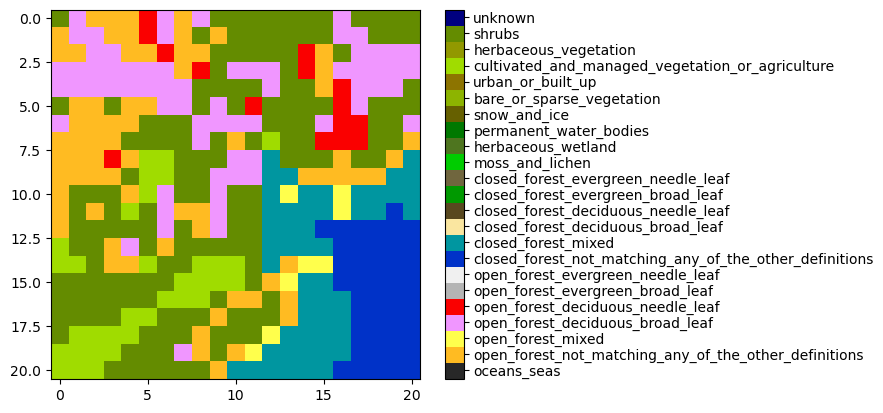

In [23]:
file = "2_27.3684, -17.479.png" # "1_27.3348, -16.9727.png"
generate_land_cover_image(satellite_image_name=file, input_file = data) #6_28.7472, -16.504.png
show_land_cover(file)

In [22]:
import os

dataset_list = os.listdir('dataset')
for image in dataset_list:
    if image == '.DS_Store':
        continue
    generate_land_cover_image(satellite_image_name=image, input_file = data)

image: 230_28.7674, -9.2638.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


image: 180_26.8076, -17.5118.png
image: 41_27.487, -17.1949.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 71_27.1016, -16.7564.png
image: 156_27.0945, -16.88.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 142_27.0137, -17.8282.png
image: 52_27.4979, -16.8157.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 19_27.096, -17.1596.png
image: 53_28.1461, -16.6109.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 131_28.3505, -15.8041.png
image: 73_27.3124, -16.6745.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 23_28.3936, -15.9533.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


image: 251_28.7678, -9.3542.png
image: 36_27.8718, -16.8085.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 160_28.7512, -16.02.png
image: 184_27.4082, -17.2402.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 2_27.3684, -17.479.png
image: 20_27.0874, -17.278.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 49_26.7811, -17.2861.png
image: 111_27.4826, -17.1946.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 185_27.1188, -17.495.png
image: 147_28.144, -16.6128.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 183_27.3579, -17.1384.png
image: 244_28.8134, -9.354.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 149_27.2236, -17.3601.png
image: 56_28.3866, -16.4878.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 31_28.3869, -16.2994.png
image: 177_27.3478, -17.345.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 75_26.9078, -17.0544.png
image: 48_27.3089, -16.6763.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 250_28.8136, -9.3992.png
image: 51_27.58, -16.5807.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 163_27.3114, -16.6792.png
image: 207_8.7701, 3.7545.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 200_8.8124, 3.7315.png
image: 143_26.7716, -17.2736.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 202_8.5053, 3.4465.png
image: 30_27.5233, -17.1292.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 9_27.0404, -17.0764.png
image: 164_28.5334, -16.4619.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 57_26.789, -17.7372.png
image: 195_8.7743, 3.7332.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 216_-5.6408, 9.4614.png
image: 206_8.9087, 3.7018.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 45_27.5423, -16.6948.png
image: 104_27.9025, -16.7466.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 16_28.3939, -16.4838.png
image: 68_28.702, -16.029.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 205_8.8945, 3.6132.png
image: 102_27.52, -17.123.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 242_28.8129, -9.2636.png
image: 79_28.0884, -16.47.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 10_26.9083, -16.9772.png
image: 26_28.766, -16.0262.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 14_26.6205, -17.3987.png
image: 39_27.6687, -17.0045.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 254_28.7676, -9.309.png
image: 226_28.8136, -9.3992.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 135_27.6796, -16.9912.png
image: 217_-5.6408, 9.4614.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 110_26.9105, -17.1593.png
image: 162_27.8092, -16.6384.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 58_26.926, -17.3093.png
image: 197_8.7833, 3.7493.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 4_28.3002, -16.3921.png
image: 198_8.7901, 3.7455.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 3_22.86, -6.478.png
image: 22_27.0861, -16.8739.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 1_27.3348, -16.9727.png
image: 203_8.5637, 3.4127.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 24_27.8436, -16.3976.png
image: 222_28.7221, -9.3092.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 65_28.3954, -15.9529.png
image: 193_8.7652, 3.736.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 208_8.6858, 3.7211.png
image: 191_8.7852, 3.7304.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 100_27.2562, -16.7782.png
image: 210_31.379, 1.8387.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 243_28.8136, -9.3992.png
image: 5_27.2753, -17.4616.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 67_27.4244, -16.806.png
image: 91_26.9042, -16.9773.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 8_27.3486, -17.3507.png
image: 181_27.7227, -16.8271.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 13_28.116, -16.6083.png
image: 150_28.387, -16.4872.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 97_27.369, -17.1354.png
image: 37_28.813, -16.1296.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 248_28.7674, -9.2638.png
image: 130_27.8989, -16.7487.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 173_28.2884, -16.3974.png
image: 84_27.3794, -16.7495.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 234_28.7674, -9.2638.png
image: 138_27.1023, -16.7507.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 174_27.279, -17.4329.png
image: 228_28.7221, -9.3092.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 18_26.9143, -17.3214.png
image: 40_26.9062, -17.1497.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 151_26.8154, -17.7287.png
image: 171_27.3526, -16.9688.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 63_28.702, -16.4214.png
image: 43_28.5265, -16.1371.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 178_27.035, -17.0752.png
image: 218_-5.0365, 7.6922.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 46_27.0369, -17.8259.png
image: 219_-5.0365, 7.6922.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 128_27.5226, -17.1275.png
image: 176_27.2393, -16.9373.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 74_28.5253, -16.4479.png
image: 11_12.6756, -1.8496.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 6_28.7472, -16.504.png
image: 247_28.8131, -9.3088.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 186_-4.181, 5.961.png
image: 90_27.0428, -17.0795.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 70_27.797, -16.6438.png
image: 235_28.8129, -9.2636.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 255_28.7674, -9.2638.png
image: 166_28.0283, -16.3176.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 15_27.221, -17.3594.png
image: 211_31.31, 1.7305.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 87_28.7471, -16.503.png
image: 252_28.8134, -9.354.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 61_27.0973, -17.1647.png
image: 44_28.5802, -16.2137.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 215_-13.5078, 16.1506.png
image: 175_28.7485, -16.5032.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 249_28.8129, -9.2636.png
image: 69_28.4383, -16.5391.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 199_8.7867, 3.7385.png
image: 246_28.7676, -9.309.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 188_8.7995, 3.7508.png
image: 212_31.4206, 1.7586.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 123_27.3634, -17.1397.png
image: 133_28.8082, -16.1326.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 213_31.4476, 1.7348.png
image: 88_27.2452, -16.9304.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 55_27.2136, -17.3602.png
image: 167_28.29, -15.8698.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 137_27.4855, -17.194.png
image: 82_ 27.3641, -17.4814.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 47_27.8138, -16.6244.png
image: 99_27.1284, -17.4951.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 245_28.7221, -9.3092.png
image: 260_37.1085, -6.934.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 12_12.6756, -1.8496.png
image: 152_26.9197, -17.2991.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 28_27.2488, -16.7705.png
image: 148_26.6015, -17.4086.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 231_28.8134, -9.354.png
image: 262_37.0806, -6.9507.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 117_28.6958, -16.5186.png
image: 261_37.1085, -6.934.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 120_26.7939, -17.5082.png
image: 127_27.9724, -16.4845.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 146_27.5011, -16.8223.png
image: 129_28.3961, -16.2991.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 157_28.3867, -15.9479.png
image: 86_27.2667, -17.4586.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 237_28.8134, -9.354.png
image: 109_27.6737, -16.9949.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 145_27.5808, -16.5735.png
image: 258_37.1142, -6.9705.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 194_8.7662, 3.7448.png
image: 96_27.0257, -17.6747.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 119_27.504, -16.83.png
image: 223_28.7676, -9.309.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 33_8.7158, 3.719.png
image: 187_8.7906, 3.7514.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 50_28.6928, -16.5203.png
image: 168_27.3784, -16.7559.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 161_28.435, -16.5487.png
image: 236_28.8136, -9.3992.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 93_27.7259, -16.8253.png
image: 182_27.555, -17.0575.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 169_28.0936, -16.4787.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


image: 106_27.8712, -16.8128.png
image: 239_28.7676, -9.309.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 76_28.0421, -16.3063.png
image: 192_8.7752, 3.7403.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 25_27.426, -16.8164.png
image: 59_28.5262, -16.4516.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 165_26.9111, -17.0574.png
image: 201_8.8355, 3.7277.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 72_28.0543, -16.3095.png
image: 60_26.9169, -17.0538.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 32_8.7485, 3.7219.png
image: 241_28.7674, -9.2638.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 144_28.6938, -16.5177.png
image: 103_28.3968, -16.2983.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 94_27.5633, -17.0529.png
image: 64_27.0831, -16.8964.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 38_27.5745, -16.9203.png
image: 95_ 28.0924, -16.478.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 153_27.0947, -17.1702.png
image: 62_27.0902, -17.2753.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 114_27.5179, -16.6834.png
image: 107_28.8067, -16.1301.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 27_28.4504, -16.5299.png
image: 113_28.6029, -16.1947.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 209_31.4125, 1.9001.png
image: 21_28.728, -16.3916.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 155_28.7282, -16.3984.png
image: 224_28.7674, -9.2638.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 238_28.7221, -9.3092.png
image: 34_27.9235, -16.7474.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 92_26.8034, -17.5093.png
image: 240_28.8131, -9.3088.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 140_28.5963, -16.198.png
image: 17_26.7929, -17.7217.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 66_27.8511, -16.3932.png
image: 220_28.8136, -9.3992.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 221_28.8134, -9.354.png
image: 263_37.0806, -6.9507.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 54_26.606, -17.4113.png
image: 179_26.8911, -16.9794.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 204_8.5538, 3.4591.png
image: 81_27.3409, -16.9638.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 189_8.7861, 3.7566.png
image: 134_27.5784, -16.9179.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 121_27.728, -16.843.png
image: 139_28.5175, -16.1366.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 259_37.0708, -6.9666.png
image: 78_27.3848, -16.7555.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 196_8.7624, 3.7275.png
image: 80_27.0765, -17.6552.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 172_27.3593, -17.49.png
image: 29_27.9688, -16.4783.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 232_28.7221, -9.3092.png
image: 141_27.537, -16.6869.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 125_27.0942, -17.5045.png
image: 170_27.0702, -17.6654.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 225_28.8129, -9.2636.png
image: 124_27.4001, -17.2378.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 159_27.4273, -16.8072.png
image: 158_27.8578, -16.3853.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 85_28.2995, -16.3971.png
image: 154_27.0849, -17.2758.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 229_28.7676, -9.309.png
image: 77_28.2918, -15.8708.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 115_27.0465, -17.8243.png
image: 35_28.3505, -15.8004.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 42_27.101, -16.7535.png
image: 105_28.3423, -15.7932.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 83_28.2964, -15.8766.png
image: 112_28.5173, -16.136.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 190_8.7772, 3.7513.png
image: 132_27.8793, -16.8082.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 101_27.9685, -16.477.png
image: 98_27.3951, -17.2411.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 214_-13.5078, 16.1506.png
image: 253_28.7221, -9.3092.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 256_28.8129, -9.2636.png
image: 227_28.8134, -9.354.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 118_27.5754, -16.582.png
image: 136_26.9214, -17.1513.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 116_26.7666, -17.269.png
image: 126_27.2559, -16.7697.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 108_27.5698, -16.9316.png
image: 122_27.5577, -17.0579.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 89_27.3704, -17.3492.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


image: 233_28.7676, -9.309.png
image: 7_27.2398, -16.9338.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py

image: 257_37.0777, -6.9524.png


/var/folders/6q/tqz51zjj4vddtmz9dylln8fw0000gn/T/ipykernel_5970/558233899.py:8: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
/Users/henrik/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
